In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
train = None
labels = None
for i in range(1,6):
    batch = unpickle("cifar-10-batches-py/data_batch_{}".format(i))
    if train is None:
        train = batch[b'data'].astype(np.float32)/255.0
        labels = batch[b'labels']
    else:
        train = np.concatenate((train, \
            batch[b'data'].astype(np.float32)/255.0), axis = 0)
        labels.extend(batch[b'labels'])
        
train_data = train
train_labels = np.array(labels).reshape((-1,1))

# Load test data
test = unpickle("cifar-10-batches-py/test_batch")
test_data = test[b'data'].astype(np.float32)/255.0
test_labels = np.array(test[b'labels']).reshape((-1,1))

label_names = unpickle("cifar-10-batches-py/batches.meta")

In [8]:
train_images = np.array([np.transpose(np.reshape(image, (-1, 3, 32, 32)), (0, 2, 3, 1))[0] for image in train_data])
test_images = np.array([np.transpose(np.reshape(image, (-1, 3, 32, 32)), (0, 2, 3, 1))[0] for image in test_data])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

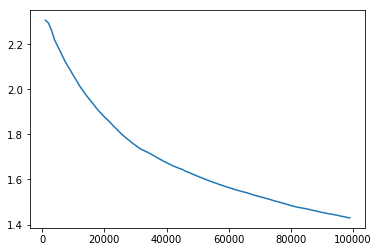

In [5]:
average_loss = []
steps = list(range(1000,100000,1000))
running_loss = 0.0
for epoch in range(2):  # loop over the dataset multiple times

    
    for i, image in enumerate(train_images):
        # get the inputs; data is a list of [inputs, labels]
        label = torch.tensor(train_labels[i])
        # zero the parameter gradients
        optimizer.zero_grad()
        transposed_image = np.transpose(image, (2,1,0))

        # Batch size 1 = Stochastic Gradient Descent
        outputs = net(torch.Tensor(transposed_image[None,:,:,:]))

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step_num = epoch * 50000 + i
        if step_num in steps:
            average_loss.append(running_loss/step_num)
plt.plot(steps, average_loss)
plt.show()

In [16]:
def classify_example(image):
    transposed_image = np.transpose(image, (2,1,0))
    outputs = net(torch.Tensor(transposed_image[None,:,:,:]))
    probs = torch.squeeze(F.softmax(outputs, dim = 1))
    return torch.argmax(probs).item()
correct = 0
total = 0
for i, image in enumerate(test_images):
    if classify_example(image) == test_labels[i]:
        correct += 1
    total += 1
correct/total

0.5774